# Соревнование для учащися курса "Специалист по работе с данными / Data Scientist". Школа 21 СБЕР / Томский государственный университет

https://www.kaggle.com/competitions/sber-21-tgu-2022/data

Задача - предсказать стоимость аренды квартир в Лондоне. Метрика - MAE.

Предварительный анализ данных см. в ноутбуке EDA.ipynb

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import chime

In [2]:
%load_ext chime

### Пропущенные значения

Для признаков, между которыми есть корреляция, использовал KNNImputer.
У независимых друг от друга признаков использовал среднее значение, равное 0, т.к. признаки стандартизованы. Сделал это зараннее, чтобы дать KNNImputer за что "зацепиться": KNN Imputer выкидывает колонки, если не может подобрать соседей, поэтому включил в список признаков долготу и широту (у них пропущенные значения уже заполнены). (Проблема с потерянными колонками возникает при преобразовании малых выборок на этапе тестирования.)

In [3]:
class Preprocess:
    def __init__(self, max_categories=6):
        self.max_categories = max_categories
        self.uncorrelated_features = ['latitude', 'longitude',
                                          'available', 'comments',
                                          'canceled', 'notice',
                                          'host_response_rate', 'host_since']
        self.correlated_features = ['accommodates', 'bathrooms', 'beds','guests_included',
                                        'security_deposit','bedrooms','minimum_nights',
                                        'extra_people','square_feet','cleaning_fee']

        # Adding latitude and longitude so that KNN does not drop features
        self.knn_features = self.correlated_features + ['latitude', 'longitude']
    
        
    def fit(self, X, y=None):    
        # Merge with other files
        calendar = pd.read_csv('calendar_availability.csv', index_col='listing_id')
        reviews = pd.read_csv('reviews_stat.csv', index_col='listing_id')
        df = X.copy().join([calendar, reviews], how='left')
        df.drop(columns='host_id', inplace=True)

        #Convert the column with the percent sign
        df['host_response_rate'] = df['host_response_rate']\
                .str.replace(r'\D+', '', regex=True)\
                .astype('float')

        # Convert datetimes into numbers for further use as a numeric variable
        # This will apply to the host_since column
        self.date_features = df.select_dtypes(include='datetime').columns.to_list()
        df[self.date_features] = df[self.date_features].astype(np.int64)

        self.numeric_features = df.select_dtypes(include='number').columns.to_list()
        self.cat_features = df.select_dtypes(include=['object', 'bool']).columns.to_list()
        
        self.scaler = StandardScaler().fit(df[self.numeric_features])

        impute_encode = ColumnTransformer(
            transformers = [
                ('corr', KNNImputer(n_neighbors=50), self.knn_features),
                ('get_dummies', OneHotEncoder(sparse=False,
                                              drop='first', 
                                              handle_unknown='infrequent_if_exist',
                                              min_frequency=2,
                                             max_categories=self.max_categories), self.cat_features)
            ],
            remainder='passthrough',
            n_jobs=-1
        )

        self.pipe_impute_encode = Pipeline([('impute_encode', impute_encode)]).fit(df)
        
        return self

    
    def transform(self, X, y=None):
        # Merge with other files
        calendar = pd.read_csv('calendar_availability.csv', index_col='listing_id')
        reviews = pd.read_csv('reviews_stat.csv', index_col='listing_id')
        df = X.copy().join([calendar, reviews], how='left')
        df.drop(columns='host_id', inplace=True)

        #Convert the column with the percent sign
        df['host_response_rate'] = df['host_response_rate']\
                .str.replace(r'\D+', '', regex=True)\
                .astype('float')

        # Convert datetimes into numbers for further use as a numeric variable
        # This will apply to the host_since column
        df[self.date_features] = df[self.date_features].astype(np.int64)

        df[self.numeric_features] = pd.DataFrame(
                self.scaler.transform(df[self.numeric_features]),
                columns=self.numeric_features,
                index=df.index
            )

        # Filling NaNs in uncorrelated features
        df[self.uncorrelated_features] = df[self.uncorrelated_features].fillna(0, axis=0)

        result = self.pipe_impute_encode.transform(df)
            
        return result

In [8]:
train = pd.read_csv('train.csv',
                    index_col='id',
                    true_values=['t'],
                    false_values=['f'],
                    na_values='none',
                    parse_dates=['host_since'],
                   low_memory=False)
train

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,...,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,price
id,,,,,,,,,,,,,,,,,,,,,
20145777,Double in a friendly house,A double bedroom in a cozy and modern apartm...,NaN,A double bedroom in a cozy and modern apartm...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,0.0,1,flexible,False,False,90.0
22630537,London flat with great transport links,"Light, airy and modern one bedroom flat 2 mins...",NaN,"Light, airy and modern one bedroom flat 2 mins...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25.0,2,20.0,1,moderate,False,False,75.0
27355619,"Studio Apartments, 5 mins to Kings Cross Station!","Based in high quality student accommodation, o...",What To Expect: * 16/17m2 Studio with modern f...,"Based in high quality student accommodation, o...",NaN,As one of Central London’s most vibrant and ne...,• Do you have free WiFi? Yes we have super fas...,You will be in an incredible position for gett...,"You will enjoy your own studio, with a private...",Our reception can help you out with anything y...,...,NaN,80.0,45.0,1,0.0,3,flexible,False,False,89.0
21011236,"Big, Beautiful, Sunny, West Kensington TWIN Room","Big Beautiful, airy, West Kensington TWIN room...",This is a pretty terraced house in a great are...,"Big Beautiful, airy, West Kensington TWIN room...",NaN,We’re in a fantastic location - close to many ...,We lay on a good breakfast that guests serve t...,NaN,The room is exclusively yours while you're her...,I'm Matthew and I live here with my son Alex. ...,...,NaN,NaN,12.0,1,11.0,1,moderate,False,False,60.0
24754494,Dashing 1BR in Bayswater by Sonder,"At this Sonder, you'll love the chic decor, st...",Every booking is instantly confirmed. Every ca...,"At this Sonder, you'll love the chic decor, st...",NaN,"Your Sonder is in a beautiful dwelling, conver...","This Sonder does not have air conditioning, bu...",Your Sonder is located at the end of a cul-de-...,NaN,"Our concierge is available by phone, email, or...",...,NaN,300.0,63.0,2,5.0,2,strict_14_with_grace_period,False,False,169.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18151315,Sunny studio with private kitchen and bathroom,"Quiet, sunny studio flat just minutes from the...",A small and very cosy flat with all necessary ...,"Quiet, sunny studio flat just minutes from the...",NaN,Crystal Palace is a vibrant bohemian oasis sur...,NaN,"2 mins to Gipsy Hill Rail, direct links to Vi...",You have shared access through main front door...,I have an apartment manager who lives close by...,...,NaN,NaN,25.0,1,0.0,2,moderate,False,False,65.0
28105053,A comfy double room in modern flat ★ Haggerston,It's a double room for 2 guests.,NaN,It's a double room for 2 guests. I will be at ...,NaN,NaN,NaN,There is Haggerston overground station only 3 ...,NaN,I will be at the Airbnb to greet you and check...,...,NaN,0.0,10.0,1,10.0,2,strict_14_with_grace_period,False,False,31.0
26342100,Goldsborough House - Apartment London SW8,"Spacious three bedroom flat, fantastic locatio...",NaN,"Spacious three bedroom flat, fantastic locatio...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1,0.0,1,flexible,False,False,150.0


In [9]:
X = train.drop(columns='price')
y = train.price

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2,
                                                  random_state=8,
                                                 shuffle=True)

In [50]:
X_val.shape

(7254, 41)

In [27]:
%%time
%%chime
preprocess = Preprocess().fit(X_train)

CPU times: total: 1.02 s
Wall time: 2min 24s


In [28]:
%%time
%%chime
X_train_transf = preprocess.transform(X_train)

CPU times: total: 1.39 s
Wall time: 1min 16s


In [29]:
X_train_transf.shape

(29016, 118)

In [30]:
%%time
%%chime
X_val_transf = preprocess.transform(X_val)

CPU times: total: 859 ms
Wall time: 14.8 s


In [31]:
X_val_transf.shape

(7254, 118)

In [29]:
np.save('X_train_transf', X_train_transf)
np.save('X_val_transf', X_val_transf)
np.save('y_train', y_train)
np.save('y_val', y_val)

In [4]:
X_train_transf = np.load('X_train_transf.npy')
y_train = np.load('y_train.npy')

In [ ]:
X_val_transf = np.load('X_val_transf.npy')
y_val = np.load('y_val.npy')

# PCA

In [21]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components=None, random_state=8).fit(X_train_transf)

In [31]:
pca.explained_variance_ratio_[:10]

array([0.64161609, 0.32723385, 0.0137343 , 0.00292418, 0.00162794,
       0.00102086, 0.00100115, 0.00089108, 0.00088811, 0.00083579])

<AxesSubplot:>

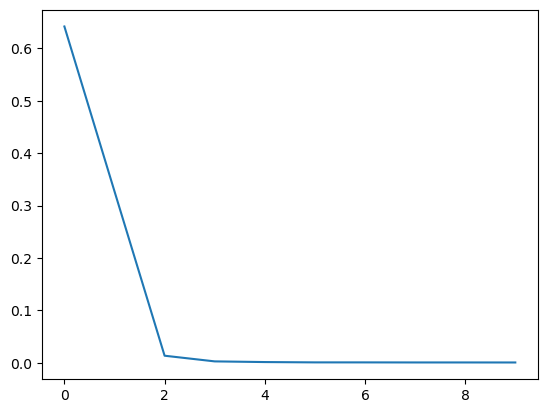

In [30]:
pd.Series(pca.explained_variance_ratio_)[:10].plot.line()


Первые 2 главные компоненты объясняют 97% изменений.

In [35]:
X_train_transf_pca = PCA(n_components=2, random_state=8).fit_transform(X_train_transf)
X_val_transf_pca = PCA(n_components=2, random_state=8).fit_transform(X_val_transf)

In [36]:
np.save('X_train_transf_pca', X_train_transf_pca)
np.save('X_val_transf_pca', X_val_transf_pca)

In [4]:
X_train_transf_pca = np.load('X_train_transf_pca.npy')
X_val_transf_pca = np.load('X_val_transf_pca.npy')

# Выбор модели

## Предсказание по средней цене

In [16]:
y_val.describe()

count    7254.000000
mean      115.931624
std       175.953193
min         0.000000
25%        45.000000
50%        85.000000
75%       135.000000
max      7716.000000
Name: price, dtype: float64

In [17]:
(y_val - y_val.mean()).abs().mean()

74.18344137864436

## Линейная регрессия

In [37]:
from sklearn.linear_model import ElasticNet

Можно было бы использовать ElasticNetCV, но использую GridSearchCV, т.к. в нем можно задавать целевую метрику (по условиям задачи - mae).

In [30]:
params = {'alpha': np.arange(0.2, 1.0, 0.1).tolist() + np.arange(1.0, 10, 1).tolist(),
         'l1_ratio': [0.1, 0.5, 0.8, 0.95, 0.99, 1]}

In [31]:
regressor = ElasticNet(max_iter=1000,
                       random_state=8)
lin_reg = GridSearchCV(estimator = regressor,
                      param_grid = params,
                      scoring='neg_mean_absolute_error',
                      n_jobs=-1, 
                      refit=True,
                      cv=5)

In [32]:
%%time
%%chime
lin_reg.fit(X_train_transf, y_train)

CPU times: total: 2.64 s
Wall time: 34.7 s


In [33]:
lin_reg.best_score_

-50.23529492470278

In [34]:
lin_reg.best_params_

{'alpha': 0.2, 'l1_ratio': 0.5}

Сужаю сетку

In [35]:
params = {'alpha': np.arange(0.01, 0.3, 0.01).tolist(),
         'l1_ratio': np.arange(0.1, 0.8, 0.1).tolist()}

In [36]:
regressor = ElasticNet(max_iter=1000,
                       random_state=8)
lin_reg = GridSearchCV(estimator = regressor,
                      param_grid = params,
                      scoring='neg_mean_absolute_error',
                      n_jobs=-1, 
                      refit=True,
                      cv=5)

In [37]:
%%time
%%chime
lin_reg.fit(X_train_transf, y_train)

CPU times: total: 4.94 s
Wall time: 1min 28s


In [38]:
lin_reg.best_score_

-50.219389612363216

In [39]:
lin_reg.best_params_

{'alpha': 0.13, 'l1_ratio': 0.1}

## Линейная регрессия с PCA

In [38]:
params = {'alpha': np.arange(0.2, 1.0, 0.1).tolist() + np.arange(1.0, 10, 1).tolist(),
         'l1_ratio': [0.1, 0.5, 0.8, 0.95, 0.99, 1]}

In [39]:
regressor = ElasticNet(max_iter=1000,
                       random_state=8)
lin_reg = GridSearchCV(estimator = regressor,
                      param_grid = params,
                      scoring='neg_mean_absolute_error',
                      n_jobs=4, 
                      refit=True,
                      cv=5)

In [40]:
%%time
%%chime
lin_reg.fit(X_train_transf_pca, y_train)

CPU times: total: 703 ms
Wall time: 4.77 s


In [41]:
lin_reg.best_score_

-73.8737562278529

Результат гораздо хуже

## Дерево решений

In [5]:
from sklearn.tree import DecisionTreeRegressor

In [49]:
params = {'max_depth':[10, 100, None],
          'max_features': ['sqrt', None]
         }

In [50]:
regressor = DecisionTreeRegressor(criterion='absolute_error', 
                                  random_state=8)
tree = GridSearchCV(estimator = regressor,
                      param_grid = params,
                      scoring='neg_mean_absolute_error',
                      n_jobs=-1, 
                      refit=True,
                      cv=5)

In [51]:
%%time
%%chime
tree.fit(X_train_transf, y_train)

CPU times: total: 2min 56s
Wall time: 12min 27s


In [52]:
tree.best_score_

-42.682389729141505

In [53]:
tree.best_params_

{'max_depth': 10, 'max_features': None}

Сужаю сеть

In [54]:
params = {'max_depth': [5, 10, 20, 30, 50],
          'max_features': [None]
         }

In [55]:
regressor = DecisionTreeRegressor(criterion='absolute_error', 
                                  random_state=8)
tree = GridSearchCV(estimator = regressor,
                      param_grid = params,
                      scoring='neg_mean_absolute_error',
                      n_jobs=-1, 
                      refit=True,
                      cv=5)

In [56]:
%%time
%%chime
tree.fit(X_train_transf, y_train)

CPU times: total: 2min 56s
Wall time: 17min 16s


In [57]:
tree.best_score_

-42.682389729141505

In [58]:
tree.best_params_

{'max_depth': 10, 'max_features': None}

## Дерево решений с PCA

In [45]:
params = {'max_depth':[10, 100, None],
          'max_features': ['sqrt', None]
         }

In [46]:
regressor = DecisionTreeRegressor(criterion='absolute_error', 
                                  random_state=8)
tree_pca = GridSearchCV(estimator = regressor,
                      param_grid = params,
                      scoring='neg_mean_absolute_error',
                      n_jobs=4, 
                      refit=True,
                      cv=5)

In [47]:
%%time
%%chime
tree_pca.fit(X_train_transf_pca, y_train)

CPU times: total: 7.33 s
Wall time: 1min 4s


In [49]:
tree_pca.best_score_

-54.316324691487196

Результат гораздо хуже

## Случайный лес

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
params = {'max_depth':[10, 25],
          'max_features': ['sqrt', None],
          'max_samples': [0.5, 1.0]
         }

In [15]:
regressor = RandomForestRegressor(n_estimators=100, 
                                  criterion='absolute_error',
                                  bootstrap=True, 
                                  oob_score=False, 
                                  n_jobs=4,
                                  random_state=8)
forest = GridSearchCV(estimator = regressor,
                      param_grid = params,
                      scoring='neg_mean_absolute_error',
                      n_jobs=4, 
                      refit=True,
                      cv=5)

In [16]:
%%time
%%chime
forest.fit(X_train_transf, y_train)

CPU times: total: 16min 2s
Wall time: 5h 41min 38s


In [17]:
forest.best_score_

-37.57048363370001

In [18]:
forest.best_params_

{'max_depth': 25, 'max_features': 'sqrt', 'max_samples': 1.0}

Сужаю сеть

In [19]:
params = {'max_depth':[15, 25, 50, 100],
          'max_features': ['sqrt'],
          'max_samples': [1.0]
         }

In [20]:
regressor = RandomForestRegressor(n_estimators=100, 
                                  criterion='absolute_error',
                                  bootstrap=True, 
                                  oob_score=False, 
                                  n_jobs=4,
                                  random_state=8)
forest = GridSearchCV(estimator = regressor,
                      param_grid = params,
                      scoring='neg_mean_absolute_error',
                      n_jobs=4, 
                      refit=True,
                      cv=5)

In [21]:
%%time
%%chime
forest.fit(X_train_transf, y_train)

CPU times: total: 15min 32s
Wall time: 55min 44s


In [22]:
forest.best_score_

-37.16204049626532

In [23]:
forest.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'max_samples': 1.0}

## Градиентный бустинг

In [6]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [38]:
params = {'max_iter': [100, 200, 300],
          'max_depth':[20, 50, 70],
          'l2_regularization': [0.0, 0.2]
         }

In [39]:
regressor = HistGradientBoostingRegressor(loss='absolute_error',
                                          learning_rate=0.1, 
                                          early_stopping='auto',
                                          scoring='loss',
                                          validation_fraction=0.1,
                                          n_iter_no_change=10,
                                          tol=1e-07, 
                                          random_state=8) 
boost = GridSearchCV(estimator = regressor,
                      param_grid = params,
                      scoring='neg_mean_absolute_error',
                      n_jobs=4, 
                      refit=True,
                      cv=5)

In [40]:
%%time
%%chime
boost.fit(X_train_transf, y_train)

CPU times: total: 17.7 s
Wall time: 3min 26s


In [41]:
boost.best_score_

-34.039898838658004

In [42]:
boost.best_params_

{'l2_regularization': 0.2, 'max_depth': 20, 'max_iter': 300}

Сужаю сеть

In [43]:
params = {'max_iter': [300, 400, 500],
          'max_depth':[15, 20, 30],
          'l2_regularization': [0.2, 0.3]
         }

In [44]:
regressor = HistGradientBoostingRegressor(loss='absolute_error',
                                          learning_rate=0.1, 
                                          early_stopping='auto',
                                          scoring='loss',
                                          validation_fraction=0.1,
                                          n_iter_no_change=10,
                                          tol=1e-07, 
                                          random_state=8) 
boost = GridSearchCV(estimator = regressor,
                      param_grid = params,
                      scoring='neg_mean_absolute_error',
                      n_jobs=4, 
                      refit=True,
                      cv=5)

In [45]:
%%time
%%chime
boost.fit(X_train_transf, y_train)

CPU times: total: 17.2 s
Wall time: 4min 23s


In [46]:
boost.best_score_

-34.03641473020365

In [47]:
boost.best_params_

{'l2_regularization': 0.2, 'max_depth': 20, 'max_iter': 400}

## Градиентный бустинг с PCA

In [52]:
params = {'max_iter': [100, 200, 300],
          'max_depth':[20, 50, 70],
          'l2_regularization': [0.0, 0.2]
         }

In [53]:
regressor = HistGradientBoostingRegressor(loss='absolute_error',
                                          learning_rate=0.1, 
                                          early_stopping='auto',
                                          scoring='loss',
                                          validation_fraction=0.1,
                                          n_iter_no_change=10,
                                          tol=1e-07, 
                                          random_state=8) 
boost_pca = GridSearchCV(estimator = regressor,
                      param_grid = params,
                      scoring='neg_mean_absolute_error',
                      n_jobs=4, 
                      refit=True,
                      cv=5)

In [54]:
%%time
%%chime
boost_pca.fit(X_train_transf_pca, y_train)

CPU times: total: 5.5 s
Wall time: 24.5 s


In [55]:
boost_pca.best_score_

-51.51882437983909

Результат гораздо хуже

## Нейронная сеть

In [5]:
from sklearn.neural_network import MLPRegressor

In [7]:
params = {'hidden_layer_sizes':[(30,), (59, 30), (59, 30, 15)],
          'alpha':[0.0001, 1]}
mlp = MLPRegressor(solver='adam',
                   learning_rate='constant',
                   learning_rate_init=0.001,
                   power_t=0.5, 
                   max_iter=200,
                   shuffle=True,
                   random_state=8,
                   early_stopping=True,
                   validation_fraction=0.1)
neural_grid = GridSearchCV(estimator=mlp,
                           param_grid=params,
                           scoring='neg_mean_absolute_error',
                           n_jobs=4,
                           refit=True,
                           cv=5)

In [8]:
%%time
%%chime
neural_grid.fit(X_train_transf, y_train)

CPU times: total: 26.3 s
Wall time: 2min 10s


In [9]:
neural_grid.best_score_

-46.128896208301306

In [10]:
neural_grid.best_params_

{'alpha': 0.0001, 'hidden_layer_sizes': (59, 30, 15)}

Сужаю сеть

In [12]:
params = {'hidden_layer_sizes':[(59, 30, 15), (64, 32, 16, 8), (64, 32, 16, 8, 4)],
          'alpha': np.logspace(-4, -1, 4)}
mlp = MLPRegressor(solver='adam',
                   learning_rate='constant',
                   learning_rate_init=0.001,
                   power_t=0.5, 
                   max_iter=200,
                   shuffle=True,
                   random_state=8,
                   early_stopping=True,
                   validation_fraction=0.1)
neural_grid = GridSearchCV(estimator=mlp,
                           param_grid=params,
                           scoring='neg_mean_absolute_error',
                           n_jobs=4,
                           refit=True,
                           cv=5)

In [13]:
%%time
%%chime
neural_grid.fit(X_train_transf, y_train)

CPU times: total: 25.3 s
Wall time: 4min 54s


In [14]:
neural_grid.best_score_

-46.128896208301306

In [15]:
neural_grid.best_params_

{'alpha': 0.0001, 'hidden_layer_sizes': (59, 30, 15)}

## KNN

In [5]:
from sklearn.neighbors import KNeighborsRegressor

In [9]:
params = {'n_neighbors':[5, 10, 50],
           'weights':['uniform', 'distance']}
regressor = KNeighborsRegressor(n_jobs=4)
knn = GridSearchCV(estimator=regressor,
                           param_grid=params,
                           scoring='neg_mean_absolute_error',
                           n_jobs=4,
                           refit=True,
                           cv=5)

In [10]:
%%time
%%chime
knn.fit(X_train_transf, y_train)

CPU times: total: 46.9 ms
Wall time: 18.9 s


In [12]:
knn.best_score_

-43.03942597967689

In [13]:
knn.best_params_

{'n_neighbors': 10, 'weights': 'distance'}

Сужаю сеть

In [15]:
params = {'n_neighbors':list(range(6, 50)),
           'weights':['distance']}
regressor = KNeighborsRegressor(n_jobs=4)
knn = GridSearchCV(estimator=regressor,
                           param_grid=params,
                           scoring='neg_mean_absolute_error',
                           n_jobs=4,
                           refit=True,
                           cv=5)

In [16]:
%%time
%%chime
knn.fit(X_train_transf, y_train)

CPU times: total: 547 ms
Wall time: 1min 56s


In [17]:
knn.best_score_

-42.88060923440211

In [18]:
knn.best_params_

{'n_neighbors': 13, 'weights': 'distance'}

# Stacking

In [19]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV

In [16]:
params = {'alpha': [0.1, 1, 10],
         'l1_ratio': [0.1, 0.8, 1]}

In [20]:
estimators = [('boost', HistGradientBoostingRegressor(loss='absolute_error',
                                                      l2_regularization=0.2,
                                                      max_depth=20,
                                                      max_iter =400,
                                                      learning_rate=0.1, 
                                                      early_stopping='auto',
                                                      scoring='loss',
                                                      validation_fraction=0.1,
                                                      n_iter_no_change=10,
                                                      tol=1e-07, 
                                                      random_state=8)),
              ('neural', MLPRegressor(solver='adam',
                                      alpha=0.0001,
                                      hidden_layer_sizes=(59, 30, 15),
                                       learning_rate='constant',
                                       learning_rate_init=0.001,
                                       power_t=0.5, 
                                       max_iter=200,
                                       shuffle=True,
                                       random_state=8,
                                       early_stopping=True,
                                       validation_fraction=0.1)),
              ('knn', KNeighborsRegressor(n_neighbors=13, 
                                          weights='distance',
                                          n_jobs=4))
             ]

final_estimator = RidgeCV(alphas=(0.1, 1.0, 10.0),
                          scoring='neg_mean_absolute_error',
                          cv=5)

reg = StackingRegressor(estimators=estimators,
                        final_estimator=final_estimator,
                        cv=5,
                        n_jobs=4)


In [21]:
%%time
%%chime
reg.fit(X_train_transf, y_train)

CPU times: total: 328 ms
Wall time: 1min 16s


In [26]:
reg.final_estimator_.best_score_

-40.53884289577629

In [27]:
reg.final_estimator_.alpha_

10.0

Меняю сетку

In [28]:
params = {'alpha': [5, 10, 20, 50]}

In [29]:
estimators = [('boost', HistGradientBoostingRegressor(loss='absolute_error',
                                                      l2_regularization=0.2,
                                                      max_depth=20,
                                                      max_iter =400,
                                                      learning_rate=0.1, 
                                                      early_stopping='auto',
                                                      scoring='loss',
                                                      validation_fraction=0.1,
                                                      n_iter_no_change=10,
                                                      tol=1e-07, 
                                                      random_state=8)),
              ('neural', MLPRegressor(solver='adam',
                                      alpha=0.0001,
                                      hidden_layer_sizes=(59, 30, 15),
                                       learning_rate='constant',
                                       learning_rate_init=0.001,
                                       power_t=0.5, 
                                       max_iter=200,
                                       shuffle=True,
                                       random_state=8,
                                       early_stopping=True,
                                       validation_fraction=0.1)),
              ('knn', KNeighborsRegressor(n_neighbors=13, 
                                          weights='distance',
                                          n_jobs=4))
             ]

final_estimator = RidgeCV(alphas=(0.1, 1.0, 10.0),
                          scoring='neg_mean_absolute_error',
                          cv=5)

reg = StackingRegressor(estimators=estimators,
                        final_estimator=final_estimator,
                        cv=5,
                        n_jobs=4)


In [30]:
%%time
%%chime
reg.fit(X_train_transf, y_train)

CPU times: total: 422 ms
Wall time: 1min 16s


In [31]:
reg.final_estimator_.best_score_

-40.53884289577629

In [32]:
reg.final_estimator_.alpha_

10.0

Результат градиентного бустинга улучшить не удалось.

# AdaBoost

In [7]:
from sklearn.ensemble import AdaBoostRegressor

In [9]:
best_estimator = HistGradientBoostingRegressor(loss='absolute_error',
                                              l2_regularization=0.2,
                                              max_depth=20,
                                              max_iter =400,
                                              learning_rate=0.1, 
                                              early_stopping='auto',
                                              scoring='loss',
                                              validation_fraction=0.1,
                                              n_iter_no_change=10,
                                              tol=1e-07, 
                                              random_state=8)

In [12]:
params = {'n_estimators': [5, 10, 20]}
base_estimator = best_estimator
ada = AdaBoostRegressor(base_estimator=base_estimator, 
                        loss='linear',
                        random_state=8)
ada_grid = GridSearchCV(estimator=ada,
                        param_grid=params,
                        scoring='neg_mean_absolute_error',
                        n_jobs=4,
                        refit=True,
                        cv=5)

In [13]:
%%time
%%chime
ada_grid.fit(X_train_transf, y_train)

CPU times: total: 4min 35s
Wall time: 18min 4s


In [14]:
ada_grid.best_score_

-38.59401880588925

In [15]:
ada_grid.best_params_

{'n_estimators': 10}

Результат хуже, чем без использования AdaBoost

# Окончательная модель и прогноз

In [4]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import dump, load

In [16]:
best_estimator = HistGradientBoostingRegressor(loss='absolute_error',
                                              l2_regularization=0.2,
                                              max_depth=20,
                                              max_iter =400,
                                              learning_rate=0.1, 
                                              early_stopping='auto',
                                              scoring='loss',
                                              validation_fraction=0.1,
                                              n_iter_no_change=10,
                                              tol=1e-07, 
                                              random_state=8)

Окончательный конвеер, включающий подготовку данных и регрессионную модель

In [22]:
pipe = Pipeline([
    ('prep', Preprocess()),
    ('regress', best_estimator)
])

In [23]:
%%time
%%chime
pipe.fit(X_train, y_train)

CPU times: total: 20.3 s
Wall time: 3min 48s


In [24]:
y_pred_val = pipe.predict(X_val)

In [25]:
mean_absolute_error(y_val, y_pred_val)

33.8910954153711

In [36]:
dump(pipe, 'best_model.joblib')

['best_model.joblib']

In [37]:
best_estimator_2 = load('best_model.joblib')

### Прогноз на тестовой выборке

In [45]:
X_test = pd.read_csv('test.csv',
                    index_col='id',
                    true_values=['t'],
                    false_values=['f'],
                    na_values='none',
                    parse_dates=['host_since'],
                   low_memory=False)
X_test

,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,...,amenities,square_feet,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
id,,,,,,,,,,,,,,,,,,,,,
24366684,"Luxurious 2 Bed by Kings Road, Chelsea with Ga...",This stunning newly-refurbished 2 bedroom Chel...,Amenities: - 24/7 guest support - Professiona...,This stunning newly-refurbished 2 bedroom Chel...,NaN,"Two long high streets, King's Road and Fulham ...",NaN,The flat is just a 5 minute walk from Sloane S...,Guests will have access to the entire property...,My support team or I will be contactable by em...,...,"{TV,Wifi,Kitchen,Heating,""Family/kid friendly""...",NaN,85.0,80.0,2,15.0,2,strict_14_with_grace_period,False,False
20329256,Fulham Chelsea Great Studio! HR1a,My place is close to Chelsea Football Ground. ...,cosy self contained studio - close to public t...,My place is close to Chelsea Football Ground. ...,NaN,"Fulham is a cool, vibrant area with great shop...",NaN,very close to Fulham Broadway tube & buses,NaN,happy to help,...,"{TV,Wifi,Kitchen,""Paid parking off premises"",H...",NaN,NaN,NaN,1,0.0,2,flexible,False,False
27087563,Smart Spacious Double Room with Kitchenette & ...,A spacious double room with your own private b...,A bright sunny double room with a private bath...,A spacious double room with your own private b...,NaN,"The house located in zone 2, in a quiet reside...",I have other listings in this house and you ha...,You can walk to Canary Wharf - 15 minutes. Pub...,"Apart from your own room, there is also a lar...",We work and live locally and are always availa...,...,"{TV,Internet,Wifi,Kitchen,""Buzzer/wireless int...",NaN,100.0,25.0,1,8.0,4,moderate,False,False
21995708,Beautiful 1 bedroom garden flat with lovely cat,Beautifully decorated and peaceful 1 bedroom f...,NaN,Beautifully decorated and peaceful 1 bedroom f...,NaN,The house is at the heart of London's next up ...,You will be sharing the space with our cat Kal...,15 minute walk to the Central Line and 20 minu...,NaN,NaN,...,"{Wifi,Kitchen,Heating,""Family/kid friendly"",""S...",NaN,0.0,30.0,1,0.0,3,moderate,False,False
19372467,"The Bolt Hole [440a, Fulham Road]",The Bolt Hole is a delightful 2 bedroom house ...,"An unusual house, built in the 1960's, The Bol...",The Bolt Hole is a delightful 2 bedroom house ...,NaN,The Bolt Hole is located just off Fulham Broad...,NaN,NaN,Guests are free to use the washing machine and...,NaN,...,"{TV,Wifi,Kitchen,""Free parking on premises"",He...",NaN,NaN,NaN,1,0.0,2,flexible,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19819730,"Discover Shoreditch & Hackney ""Pear""",**** Instagram @host.tay **** The Old Nags Hea...,The apartment has recently been renovated so e...,**** Instagram @host.tay **** The Old Nags Hea...,NaN,The apartment is located in Bethnal Green a vi...,NaN,The room is in the perfect location for public...,Guests can check in anytime after 2pm. At 2pm...,I'll be at the apartment most days from 11am t...,...,"{Internet,Wifi,Kitchen,Heating,""Family/kid fri...",NaN,0.0,27.0,2,15.0,2,strict_14_with_grace_period,False,False
27683820,56 Haldane Rd,Hello! I am the owner Erin J. Buchholz. Welcom...,NaN,Hello! I am the owner Erin J. Buchholz. Welcom...,NaN,NaN,NaN,NaN,NaN,NaN,...,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",NaN,NaN,NaN,1,0.0,1,flexible,False,False
21011115,A bright 2 bedroom flat in Islington,"A sunny family home with a garden, 2 double be...","Our flat is homey, quiet and has a lovely priv...","A sunny family home with a garden, 2 double be...",NaN,"The flat is on a residential street, off the m...",NaN,We are very well served for public transport t...,You will have full use of the entire flat incl...,We will contact you before your arrival to arr...,...,"{TV,Wifi,Kitchen,Heating,""Family/kid friendly"

In [52]:
%%time
%%chime
X_test_transf = preprocess.transform(X_test)

CPU times: total: 938 ms
Wall time: 31.4 s


In [53]:
X_test_transf.shape

(15545, 118)

In [54]:
y_pred_test = best_estimator.predict(X_test_transf)

In [57]:
y_pred_test = pd.DataFrame(y_pred_test, columns=['price'], index=X_test.index)
y_pred_test

,price
id,
24366684,168.801512
20329256,75.969917
27087563,46.595748
21995708,63.735783
19372467,134.891601
...,...
19819730,49.737478
27683820,102.191676
21011115,102.923678


In [58]:
y_pred_test.to_csv('submission.csv')